In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

In [ ]:
tf.config.list_physical_devices()

0 - akiec
1 - bcc
2 - bkl
3 - df
4 - nv
5 - vasc
6 - mel

In [4]:
!mkdir "Data"
!cp -r /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/* /kaggle/working/Data
!cp -r /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/* /kaggle/working/Data

In [5]:
data = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [6]:
data = data.drop(["lesion_id", "dx_type", "age", "localization", "sex"], axis=1)
data

,image_id,dx
0,ISIC_0027419,bkl
1,ISIC_0025030,bkl
2,ISIC_0026769,bkl
3,ISIC_0025661,bkl
4,ISIC_0031633,bkl
...,...,...
10010,ISIC_0033084,akiec
10011,ISIC_0033550,akiec
10012,ISIC_0033536,akiec
10013,ISIC_0032854,akiec


In [7]:
data["dx"].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [ ]:
# data["label"] = [labels[x] for x in data["dx"]]
# data

# Preprocessing the Images

In [9]:
dataPath = Path(r"/kaggle/working/Data")
print(len(os.listdir(dataPath)))

10015


In [10]:
data["image_id"] = [f"{dataPath}/{x}.jpg" for x in data["image_id"]]
data

,image_id,dx
0,/kaggle/working/Data/ISIC_0027419.jpg,bkl
1,/kaggle/working/Data/ISIC_0025030.jpg,bkl
2,/kaggle/working/Data/ISIC_0026769.jpg,bkl
3,/kaggle/working/Data/ISIC_0025661.jpg,bkl
4,/kaggle/working/Data/ISIC_0031633.jpg,bkl
...,...,...
10010,/kaggle/working/Data/ISIC_0033084.jpg,akiec
10011,/kaggle/working/Data/ISIC_0033550.jpg,akiec
10012,/kaggle/working/Data/ISIC_0033536.jpg,akiec
10013,/kaggle/working/Data/ISIC_0032854.jpg,akiec


In [11]:
train_data, test_data = train_test_split(data, test_size=.2, stratify=data.dx)
train_data, valid_data = train_test_split(data, test_size=.2, stratify=data.dx)

In [13]:
train_data.shape, valid_data.shape, test_data.shape

((8012, 2), (2003, 2), (2003, 2))

In [14]:
imageDataGenerator = ImageDataGenerator(rescale=1/255.)
train_gen = imageDataGenerator.flow_from_dataframe(train_data, x_col="image_id", y_col="dx", target_size=[224, 224], mode="categorical", batch_size=16)
valid_gen = imageDataGenerator.flow_from_dataframe(valid_data, x_col="image_id", y_col="dx", target_size=[224, 224], mode="categorical", batch_size=16)
test_gen = imageDataGenerator.flow_from_dataframe(test_data, x_col="image_id", y_col="dx", target_size=[224, 224], mode="categorical", batch_size=16)

Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [15]:
labels = train_gen.class_indices
labels

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [16]:
model = Sequential([
    layers.Input(shape=[224, 224, 3], name="Inputs"),
    layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu", name="Conv1"),
    layers.MaxPooling2D(pool_size=2, strides=2, name="maxpool1"),
    layers.BatchNormalization(name="BatchNorm1"),
    layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="Conv2"),
    layers.MaxPooling2D(pool_size=2, strides=2, name="maxpool2"),
    layers.BatchNormalization(name="BatchNorm2"),
    layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu", name="Conv3"),
    layers.MaxPooling2D(pool_size=2, strides=2, name="maxpool3"),
    layers.BatchNormalization(name="BatchNorm3"),
    layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="Conv4"),
    layers.MaxPooling2D(pool_size=2, strides=2, name="maxpool4"),
    layers.BatchNormalization(name="BatchNorm4"),
    layers.Flatten(name="GAP"),
    layers.Dense(7, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 224, 224, 16)      448       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 112, 112, 16)      0         
                                                                 
 BatchNorm1 (BatchNormalizat  (None, 112, 112, 16)     64        
 ion)                                                            
                                                                 
 Conv2 (Conv2D)              (None, 112, 112, 32)      4640      
                                                                 
 maxpool2 (MaxPooling2D)     (None, 56, 56, 32)        0         
                                                                 
 BatchNorm2 (BatchNormalizat  (None, 56, 56, 32)       128       
 ion)                                                   

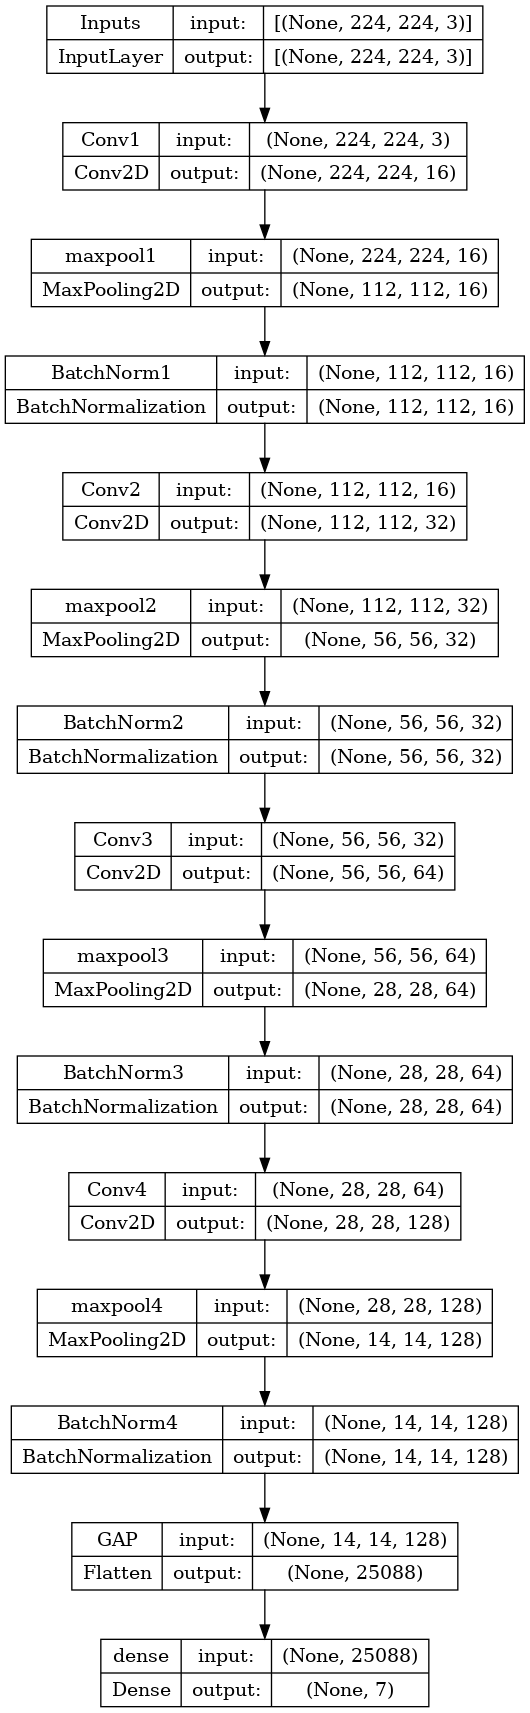

In [17]:
plot_model(model, show_layer_names=True, show_shapes=True)

In [18]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-3), metrics=['accuracy'])

In [20]:
history = model.fit(train_gen, validation_data=valid_gen, epochs=30)

Epoch 1/30
501/501 [==============================] - 75s 150ms/step - loss: 2.3877 - accuracy: 0.6162 - val_loss: 1.2313 - val_accuracy: 0.6375
Epoch 2/30
501/501 [==============================] - 66s 131ms/step - loss: 1.5230 - accuracy: 0.6555 - val_loss: 2.0645 - val_accuracy: 0.6565
Epoch 3/30
501/501 [==============================] - 65s 130ms/step - loss: 1.2396 - accuracy: 0.6838 - val_loss: 1.6817 - val_accuracy: 0.6845
Epoch 4/30
501/501 [==============================] - 65s 130ms/step - loss: 0.9811 - accuracy: 0.7108 - val_loss: 1.6780 - val_accuracy: 0.7009
Epoch 5/30
501/501 [==============================] - 65s 129ms/step - loss: 0.8892 - accuracy: 0.7259 - val_loss: 1.3283 - val_accuracy: 0.5652
Epoch 6/30
501/501 [==============================] - 64s 127ms/step - loss: 0.8726 - accuracy: 0.7400 - val_loss: 1.7140 - val_accuracy: 0.6705
Epoch 7/30
501/501 [==============================] - 65s 130ms/step - loss: 0.7683 - accuracy: 0.7575 - val_loss: 0.9403 - val_ac

In [21]:
loss, acc = model.evaluate(test_gen)

126/126 [==============================] - 13s 100ms/step - loss: 0.6639 - accuracy: 0.8842
